<a href="https://colab.research.google.com/github/jppg/py-style-transf/blob/main/AnimeGANv3_PortraitSketch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An inference notebook for [AnimeGANv3_PortraitSketch](https://github.com/TachibanaYoshino/AnimeGANv3),
Made by Asher Chan.

If you like what I'm doing you can tip me and follow on [Patreon](https://www.patreon.com/Asher_Chan).

![visitors](https://visitor-badge.glitch.me/badge?page_id=AnimeGANv3&left_color=green&right_color=red)

  
  

To start using this, run the cells with `Ctrl+F9` or "Runtime > Run All"

In [ ]:
#@title This colab is distributed under the AnimeGANv3 license
""" License

This repo is made freely available to academic and 
non-academic entities for non-commercial purposes such 
as academic research, teaching, scientific publications. 
Permission is granted to use the AnimeGANv3 given 
that you agree to my license terms. Regarding the 
request for commercial use, please contact us via 
email to help you obtain the authorization letter."""



In [ ]:
#@title Install and download. Run once.
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1F6BSJY3HibzQ08kE_al6pkXd1evxS40s' -O AnimeGANv3_PortraitSketch.onnx

!pip -qq install opencv-python
!pip -qq install numpy
!pip   install torch torchvision
!pip -qq install facenet_pytorch
!pip -qq install onnxruntime-gpu

In [ ]:
#@title Define functions
import torch
from facenet_pytorch import MTCNN
from torchvision import transforms
import onnxruntime as ort
import time, cv2, PIL
import numpy as np
from tqdm.notebook import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_name = ort.get_device()

if device_name == 'CPU':
    providers = ['CPUExecutionProvider']
elif device_name == 'GPU':
    providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']

#load model
mtcnn = MTCNN(image_size=256, margin=0, min_face_size=128, thresholds=[0.7, 0.8, 0.9], device=device)
session = ort.InferenceSession(f'/content/AnimeGANv3_PortraitSketch.onnx', providers=providers)

# MTCNN for face detection with landmarks
def detect(img):
    # Detect faces
    batch_boxes, batch_probs, batch_points = mtcnn.detect(img, landmarks=True)
    return batch_boxes, batch_points


# Expand the area around the detected face by margin {ratio} pixels
def margin_face(box, img_HW, margin=0.5):
    x1, y1, x2, y2 = [c for c in box]
    w, h = x2 - x1, y2 - y1
    new_x1 = max(0, x1 - margin*w)
    new_x2 = min(img_HW[1], x2 + margin * w)
    x_d = min(x1-new_x1, new_x2-x2)
    new_w = x2 -x1 + 2 * x_d  
    new_x1 = x1-x_d
    new_x2 = x2+x_d

    # new_h = 1.25 * new_w   
    new_h = 1.0 * new_w   

    if new_h>=h:
        y_d = new_h-h  
        new_y1 = max(0, y1 - y_d//2)
        new_y2 = min(img_HW[0], y2 + y_d//2)
    else:
        y_d = abs(new_h - h) 
        new_y1 = max(0, y1 + y_d // 2)
        new_y2 = min(img_HW[0], y2 - y_d // 2)
    return list(map(int, [new_x1, new_y1, new_x2, new_y2]))


def process_image(img, x8=True):
    h, w = img.shape[:2]
    ratio = h/w
    if x8: # resize image to multiple of 32s
        def to_8s(x):
            return 256 if x < 256 else x - x%8
        new_h = to_8s(h)
        new_w = to_8s(int(new_h/ratio))
        img = cv2.resize(img, (new_w, new_h))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)/ 127.5 - 1.0
    return img

def load_test_data(image_path):
    img0 = cv2.imread(image_path)
    batch_boxes, batch_points = detect(img0)
    if batch_boxes is None:
        print(" No face detected !")
        return
    [x1, y1, x2, y2] = margin_face(batch_boxes[0], img0.shape[:2])
    face_mat = img0[y1:y2, x1:x2]
    face_mat = process_image(face_mat)
    face_mat = np.expand_dims(face_mat, axis=0)
    return face_mat


def Convert(face_mat, img_size=[256,256]):
    x = session.get_inputs()[0].name
    y = session.get_outputs()[0].name
    fake_img = session.run(None, {x : face_mat})[0]
    output_image = (np.squeeze(fake_img) + 1.) / 2 * 255
    output_image = np.clip(output_image, 0, 255).astype(np.uint8)
    return cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)
    

in_dir = '/content/in'
out_dir = f"/content/outputs"

#setup colab interface
from google.colab import files
import ipywidgets as widgets
from IPython.display import clear_output 
from IPython.display import display
import os
from glob import glob

def reset(p):
  with output_reset:
    clear_output()
  clear_output()
  process()
 
button_reset = widgets.Button(description="Upload")
output_reset = widgets.Output()
button_reset.on_click(reset)

def fit(img, maxsize=512):
  maxdim = max(*img.size)
  if maxdim>maxsize:
    ratio = maxsize/maxdim
    x,y = img.size
    size = (int(x*ratio),int(y*ratio)) 
    img = img.resize(size)
  return img
 
def show_img(f, size=1024):
  display(fit(PIL.Image.open(f),size))


def process(upload=True):
  os.makedirs(in_dir, exist_ok=True)
  %cd {in_dir}/
  %rm -rf {out_dir}/*
  os.makedirs(out_dir, exist_ok=True)
  in_files = sorted(glob(f'{in_dir}/*'))
  if (len(in_files)==0) | (upload):
    %rm -rf {in_dir}/*
    uploaded = files.upload()
    if len(uploaded.keys())<=0: 
      print('\nNo files were uploaded. Try again..\n')
      return

  print('\nPress the button and pick some photos to upload\n')
  
  # Process the uploaded image.
  in_files = sorted(glob(f'{in_dir}/*'))
  for ims in tqdm(in_files):
    out_name = f"{out_dir}/{ims.split('/')[-1].split('.')[0]}.jpg"
    face_mat = load_test_data(ims) 
    if face_mat is None:
      return
    res = Convert(face_mat)
    cv2.imwrite(out_name, res)

  # Get the compressed package of the output results
  out_zip = f"{out_dir}.zip"
  !zip {out_zip} {out_dir}/*
    
  # Visualize the result picture
  processed = sorted(glob(f'{out_dir}/*'))[:3]
  for f in processed: 
    show_img(f, 256)



Press the button and pick some photos to upload

/content/in


Saving 055_a.jpg to 055_a.jpg

Press the button and pick some photos to upload



  0%|          | 0/1 [00:00<?, ?it/s]

  adding: content/outputs/055_a.jpg (deflated 2%)


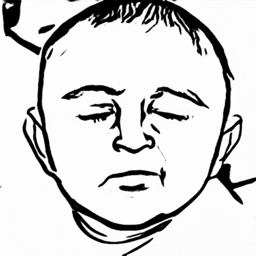

In [ ]:
#@title Click to upload files and run inference. Results will be saved and zipped.
print('\nPress the button and pick some photos to upload\n')
process()